# Product Funnel & Retention Analysis

**Objective**: Identify where users drop off in the product lifecycle and analyze early retention patterns.

**Dataset**: Google GA4 BigQuery E-commerce Demo (Public Dataset)

**Analysis Components**:
1. Funnel conversion analysis (view → add → checkout → purchase)
2. Weekly cohort retention
3. Day-N retention (D1, D7, D30)
4. Device category segmentation

## 1. Setup & Authentication

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.cloud import bigquery
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [28]:
# Initialize BigQuery client
# This will use Application Default Credentials
# Run: gcloud auth application-default login
# Or set GOOGLE_APPLICATION_CREDENTIALS environment variable

try:
    client = bigquery.Client(project="supple-comfort-483102-b2")
    print(f"✓ Successfully authenticated to BigQuery")
    print(f"  Project: {client.project}")
except Exception as e:
    print(f"✗ Authentication failed: {e}")
    print("\nPlease authenticate using one of:")
    print("  1. gcloud auth application-default login")
    print("  2. Set GOOGLE_APPLICATION_CREDENTIALS=/path/to/service-account.json")

✓ Successfully authenticated to BigQuery
  Project: supple-comfort-483102-b2


In [29]:
# Test access to public dataset
test_query = """
SELECT COUNT(*) as event_count
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20210101`
"""

try:
    result = client.query(test_query).to_dataframe()
    print(f"✓ Successfully accessed GA4 public dataset")
    print(f"  Sample event count: {result['event_count'].iloc[0]:,}")
except Exception as e:
    print(f"✗ Failed to access public dataset: {e}")

✓ Successfully accessed GA4 public dataset
  Sample event count: 22,096


## 2. Helper Functions

In [30]:
def execute_sql_from_file(filepath):
    """Execute SQL query from file and return results as DataFrame."""
    with open(filepath, 'r') as f:
        query = f.read()
    
    import re
    query = re.sub(r'/\*.*?\*/', '', query, flags=re.DOTALL)
    
    print(f"Executing: {filepath.name}...")
    df = client.query(query).to_dataframe()
    print(f"  → Returned {len(df):,} rows\n")
    return df

def validate_funnel_monotonicity(df):
    """Validate that funnel user counts decrease monotonically."""
    stages = ['reached_view', 'reached_add', 'reached_checkout', 'reached_purchase']
    counts = [df[stage].sum() for stage in stages]
    
    is_valid = all(counts[i] >= counts[i+1] for i in range(len(counts)-1))
    
    if is_valid:
        print("✓ Funnel validation passed: User counts are monotonically decreasing")
    else:
        print("✗ Funnel validation failed: User counts are NOT monotonically decreasing")
    
    for stage, count in zip(stages, counts):
        print(f"  {stage}: {count:,}")
    
    return is_valid

def calculate_conversion_rates(funnel_df):
    """Calculate stage-to-stage conversion rates from funnel data."""
    conversion_df = funnel_df.groupby('device_category').agg({
        'reached_view': 'sum',
        'reached_add': 'sum',
        'reached_checkout': 'sum',
        'reached_purchase': 'sum'
    }).reset_index()
    
    # Calculate stage-to-stage rates
    conversion_df['view_to_add'] = (conversion_df['reached_add'] / conversion_df['reached_view'] * 100).round(2)
    conversion_df['add_to_checkout'] = (conversion_df['reached_checkout'] / conversion_df['reached_add'] * 100).round(2)
    conversion_df['checkout_to_purchase'] = (conversion_df['reached_purchase'] / conversion_df['reached_checkout'] * 100).round(2)
    conversion_df['overall'] = (conversion_df['reached_purchase'] / conversion_df['reached_view'] * 100).round(2)
    
    return conversion_df

## 3. Data Extraction

In [31]:
# Define paths to SQL files
sql_dir = Path('../sql')

# Execute funnel query
funnel_df = execute_sql_from_file(sql_dir / 'funnel.sql')
print(f"Funnel data shape: {funnel_df.shape}")
print(funnel_df.head())

Executing: funnel.sql...
  → Returned 19,777 rows

Funnel data shape: (19777, 10)
        user_pseudo_id device_category    view_timestamp  add_timestamp  \
0  10007643.0797593935          mobile  1610794993803828           <NA>   
1  10010971.4068667823          mobile  1610553027257144           <NA>   
2   1001212.6261056431         desktop  1611212225249326           <NA>   
3   1001303.4827739208         desktop  1609951948655445           <NA>   
4   1001844.0963402749         desktop  1610165307563653           <NA>   

   checkout_timestamp  purchase_timestamp  reached_view  reached_add  \
0                <NA>                <NA>          True        False   
1                <NA>                <NA>          True        False   
2                <NA>                <NA>          True        False   
3                <NA>                <NA>          True        False   
4                <NA>                <NA>          True        False   

   reached_checkout  reached_purch

In [32]:
# Validate funnel logic
validate_funnel_monotonicity(funnel_df)

✓ Funnel validation passed: User counts are monotonically decreasing
  reached_view: 19,777
  reached_add: 3,320
  reached_checkout: 1,404
  reached_purchase: 1,067


True

In [33]:
# Execute retention queries
retention_weekly_df = execute_sql_from_file(sql_dir / 'retention_weekly.sql')
retention_day_n_df = execute_sql_from_file(sql_dir / 'retention_day_n.sql')

print(f"Weekly retention data shape: {retention_weekly_df.shape}")
print(f"Day-N retention data shape: {retention_day_n_df.shape}")

Executing: retention_weekly.sql...
  → Returned 36 rows

Executing: retention_day_n.sql...
  → Returned 8 rows

Weekly retention data shape: (36, 6)
Day-N retention data shape: (8, 6)


## 4. Funnel Analysis

In [34]:
# Calculate conversion rates
conversion_rates = calculate_conversion_rates(funnel_df)
print("\nFunnel Conversion Rates by Device Category:")
print(conversion_rates)


Funnel Conversion Rates by Device Category:
  device_category  reached_view  reached_add  reached_checkout  \
0         desktop         11486         1913               804   
1          mobile          7804         1336               565   
2          tablet           487           71                35   

   reached_purchase  view_to_add  add_to_checkout  checkout_to_purchase  \
0               590        16.66            42.03                 73.38   
1               448        17.12            42.29                 79.29   
2                29        14.58             49.3                 82.86   

   overall  
0     5.14  
1     5.74  
2     5.95  


In [35]:
# Overall funnel metrics
overall_metrics = funnel_df.agg({
    'reached_view': 'sum',
    'reached_add': 'sum',
    'reached_checkout': 'sum',
    'reached_purchase': 'sum'
})

print("\nOverall Funnel Metrics:")
print(f"Total Users (View): {overall_metrics['reached_view']:,}")
print(f"Add to Cart: {overall_metrics['reached_add']:,} ({overall_metrics['reached_add']/overall_metrics['reached_view']*100:.2f}%)")
print(f"Begin Checkout: {overall_metrics['reached_checkout']:,} ({overall_metrics['reached_checkout']/overall_metrics['reached_view']*100:.2f}%)")
print(f"Purchase: {overall_metrics['reached_purchase']:,} ({overall_metrics['reached_purchase']/overall_metrics['reached_view']*100:.2f}%)")


Overall Funnel Metrics:
Total Users (View): 19,777
Add to Cart: 3,320 (16.79%)
Begin Checkout: 1,404 (7.10%)
Purchase: 1,067 (5.40%)


## 5. Retention Analysis

In [36]:
# Weekly retention summary
print("Weekly Retention Summary (all devices):")
weekly_summary = retention_weekly_df.groupby('week_number').agg({
    'active_users': 'sum',
    'cohort_size': 'sum'
})
weekly_summary['retention_rate'] = (weekly_summary['active_users'] / weekly_summary['cohort_size'] * 100).round(2)
print(weekly_summary.head(10))

Weekly Retention Summary (all devices):
             active_users  cohort_size  retention_rate
week_number                                           
0                   19503        19503           100.0
1                     707        14402            4.91
2                     284         9036            3.14
3                     119         4889            2.43
4                      12         1048            1.15


In [37]:
# Day-N retention summary
print("\nDay-N Retention Summary (all devices):")
day_n_summary = retention_day_n_df.groupby('day_offset').agg({
    'active_users': 'sum',
    'cohort_size': 'sum'
})
day_n_summary['retention_rate'] = (day_n_summary['active_users'] / day_n_summary['cohort_size'] * 100).round(2)
print(day_n_summary)


Day-N Retention Summary (all devices):
            active_users  cohort_size  retention_rate
day_offset                                           
0                  19629        19629           100.0
1                    596        19629            3.04
7                    103        19156            0.54


## 6. Visualizations

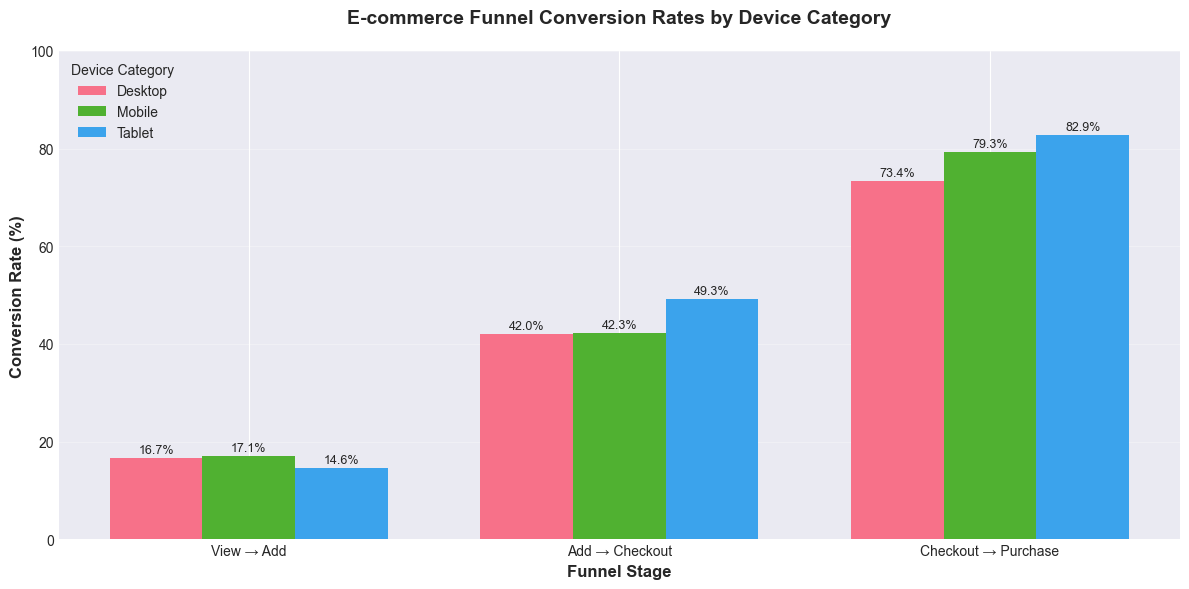

✓ Saved: funnel_conversion.png


In [38]:
# Visualization 1: Funnel Conversion Rates by Device
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for plotting
stages = ['view_to_add', 'add_to_checkout', 'checkout_to_purchase']
stage_labels = ['View → Add', 'Add → Checkout', 'Checkout → Purchase']

x = np.arange(len(stage_labels))
width = 0.25

devices = conversion_rates['device_category'].unique()
colors = sns.color_palette("husl", len(devices))

for i, device in enumerate(devices):
    device_data = conversion_rates[conversion_rates['device_category'] == device]
    values = [device_data[stage].values[0] for stage in stages]
    ax.bar(x + i * width, values, width, label=device.title(), color=colors[i])
    
    # Add value labels on bars
    for j, v in enumerate(values):
        ax.text(x[j] + i * width, v + 1, f'{v:.1f}%', ha='center', fontsize=9)

ax.set_xlabel('Funnel Stage', fontsize=12, fontweight='bold')
ax.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('E-commerce Funnel Conversion Rates by Device Category', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x + width)
ax.set_xticklabels(stage_labels)
ax.legend(title='Device Category', loc='upper left')
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/funnel_conversion.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: funnel_conversion.png")

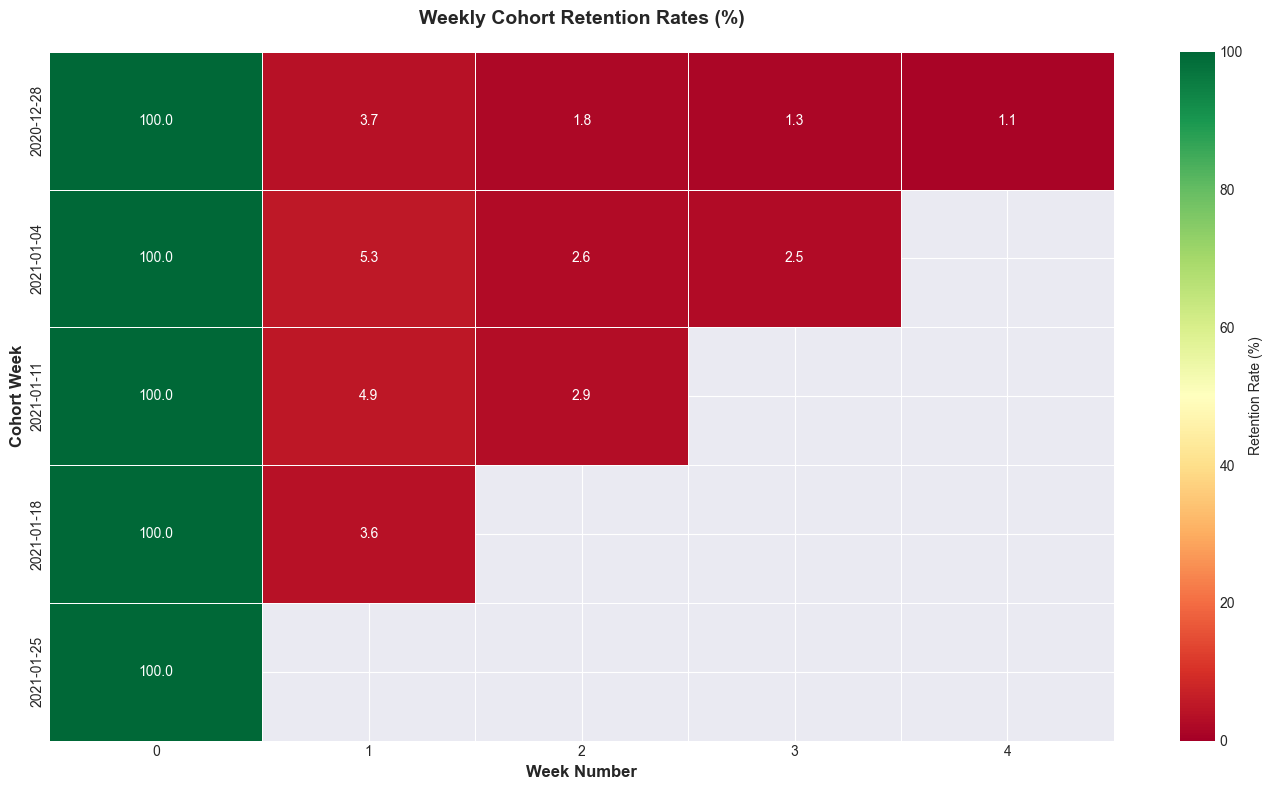

✓ Saved: retention_heatmap.png


In [39]:
# Visualization 2: Weekly Cohort Retention Heatmap
# Pivot data for heatmap
heatmap_data = retention_weekly_df.pivot_table(
    index='cohort_week',
    columns='week_number',
    values='retention_rate',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(14, 8))

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.1f',
    cmap='RdYlGn',
    cbar_kws={'label': 'Retention Rate (%)'},
    linewidths=0.5,
    ax=ax,
    vmin=0,
    vmax=100
)

ax.set_xlabel('Week Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Cohort Week', fontsize=12, fontweight='bold')
ax.set_title('Weekly Cohort Retention Rates (%)', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../figures/retention_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: retention_heatmap.png")

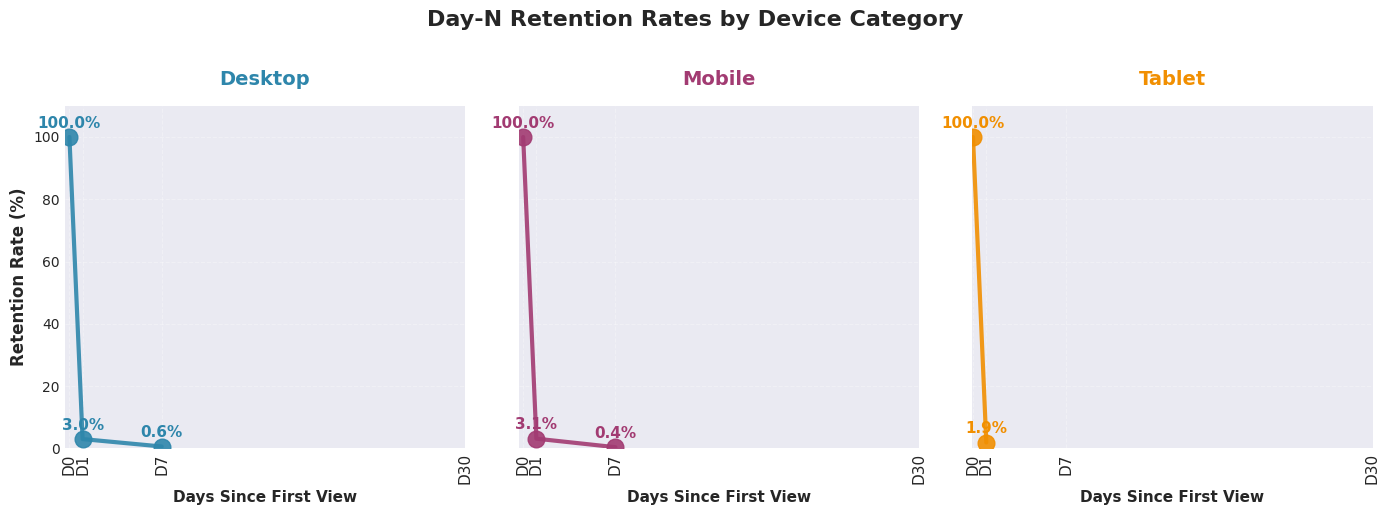

✓ Saved: retention_curves.png (small multiples chart)
✓ Each of 3 devices shown in separate panel


In [50]:
# Visualization 3: Day-N Retention by Device (SMALL MULTIPLES - SIMPLE & CLEAN)

import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['savefig.dpi'] = 300

# Create subplots - one for each device
devices = sorted(retention_day_n_df['device_category'].unique())
fig, axes = plt.subplots(1, len(devices), figsize=(14, 5), sharey=True)

colors = ['#2E86AB', '#A23B72', '#F18F01']

for idx, (ax, device) in enumerate(zip(axes, devices)):
    device_data = retention_day_n_df[
        retention_day_n_df['device_category'] == device
    ].groupby('day_offset').agg({
        'active_users': 'sum',
        'cohort_size': 'sum'
    })
    device_data['retention_rate'] = (device_data['active_users'] / device_data['cohort_size'] * 100)
    device_data = device_data.sort_index()
    
    # Simple line plot - no fill
    ax.plot(
        device_data.index,
        device_data['retention_rate'],
        marker='o',
        linewidth=3,
        markersize=12,
        color=colors[idx],
        alpha=0.9
    )
    
    # Add value labels - plenty of space in each subplot!
    for day in device_data.index:
        rate = device_data.loc[day, 'retention_rate']
        ax.text(
            day,
            rate + 3,
            f'{rate:.1f}%',
            ha='center',
            fontsize=11,
            fontweight='bold',
            color=colors[idx]
        )
    
    # Customize each subplot
    ax.set_title(device.title(), fontsize=14, fontweight='bold', color=colors[idx], pad=15)
    ax.set_xticks([0, 1, 7, 30])
    ax.set_xticklabels(['D0', 'D1', 'D7', 'D30'], fontsize=11, rotation=90)
    ax.set_ylim(0, 110)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlabel('Days Since First View', fontsize=11, fontweight='bold')

# Only leftmost chart gets y-label
axes[0].set_ylabel('Retention Rate (%)', fontsize=12, fontweight='bold')

# Overall title
fig.suptitle('Day-N Retention Rates by Device Category', fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('../figures/retention_curves.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: retention_curves.png (small multiples chart)")
print(f"✓ Each of {len(devices)} devices shown in separate panel")

## 7. Key Findings Summary

In [41]:
print("=" * 80)
print("KEY FINDINGS SUMMARY")
print("=" * 80)

# Funnel insights
print("\n1. FUNNEL ANALYSIS")
print("-" * 40)
view_to_add_overall = (overall_metrics['reached_add'] / overall_metrics['reached_view'] * 100)
add_to_checkout_overall = (overall_metrics['reached_checkout'] / overall_metrics['reached_add'] * 100)
checkout_to_purchase_overall = (overall_metrics['reached_purchase'] / overall_metrics['reached_checkout'] * 100)

print(f"Overall Conversion Rates:")
print(f"  View → Add: {view_to_add_overall:.2f}%")
print(f"  Add → Checkout: {add_to_checkout_overall:.2f}%")
print(f"  Checkout → Purchase: {checkout_to_purchase_overall:.2f}%")

# Identify largest drop-off
drop_offs = {
    'View → Add': 100 - view_to_add_overall,
    'Add → Checkout': 100 - add_to_checkout_overall,
    'Checkout → Purchase': 100 - checkout_to_purchase_overall
}
worst_stage = max(drop_offs, key=drop_offs.get)
print(f"\n  Largest Drop-off: {worst_stage} ({drop_offs[worst_stage]:.2f}% loss)")

# Retention insights
print("\n2. RETENTION ANALYSIS")
print("-" * 40)
d1_retention = day_n_summary.loc[1, 'retention_rate'] if 1 in day_n_summary.index else 0
d7_retention = day_n_summary.loc[7, 'retention_rate'] if 7 in day_n_summary.index else 0
d30_retention = day_n_summary.loc[30, 'retention_rate'] if 30 in day_n_summary.index else 0

print(f"Day-N Retention Rates:")
print(f"  D1: {d1_retention:.2f}%")
print(f"  D7: {d7_retention:.2f}%")
print(f"  D30: {d30_retention:.2f}%")

# Early vs late churn
d1_drop = 100 - d1_retention
d7_to_d30_drop = d7_retention - d30_retention
print(f"\n  Early Churn (D0→D1): {d1_drop:.2f}%")
print(f"  Late Churn (D7→D30): {d7_to_d30_drop:.2f}%")

if d1_drop > d7_to_d30_drop:
    print("  → Churn is primarily an EARLY lifecycle problem")
else:
    print("  → Churn is primarily a LATE lifecycle problem")

# Device insights
print("\n3. DEVICE SEGMENTATION")
print("-" * 40)
print("Best performing device by overall conversion:")
best_device = conversion_rates.loc[conversion_rates['overall'].idxmax(), 'device_category']
best_rate = conversion_rates.loc[conversion_rates['overall'].idxmax(), 'overall']
print(f"  {best_device.title()}: {best_rate:.2f}% overall conversion")

print("\n" + "=" * 80)

KEY FINDINGS SUMMARY

1. FUNNEL ANALYSIS
----------------------------------------
Overall Conversion Rates:
  View → Add: 16.79%
  Add → Checkout: 42.29%
  Checkout → Purchase: 76.00%

  Largest Drop-off: View → Add (83.21% loss)

2. RETENTION ANALYSIS
----------------------------------------
Day-N Retention Rates:
  D1: 3.04%
  D7: 0.54%
  D30: 0.00%

  Early Churn (D0→D1): 96.96%
  Late Churn (D7→D30): 0.54%
  → Churn is primarily an EARLY lifecycle problem

3. DEVICE SEGMENTATION
----------------------------------------
Best performing device by overall conversion:
  Tablet: 5.95% overall conversion



## 8. Data Export for Executive Summary

In [42]:
# Export key metrics for reference
summary_metrics = {
    'total_users': int(overall_metrics['reached_view']),
    'view_to_add_rate': float(view_to_add_overall),
    'add_to_checkout_rate': float(add_to_checkout_overall),
    'checkout_to_purchase_rate': float(checkout_to_purchase_overall),
    'largest_dropoff': worst_stage,
    'd1_retention': float(d1_retention),
    'd7_retention': float(d7_retention),
    'd30_retention': float(d30_retention),
    'best_device': best_device,
    'best_device_conversion': float(best_rate)
}

print("Summary metrics for executive summary:")
for key, value in summary_metrics.items():
    print(f"  {key}: {value}")

Summary metrics for executive summary:
  total_users: 19777
  view_to_add_rate: 16.787177023815545
  add_to_checkout_rate: 42.28915662650603
  checkout_to_purchase_rate: 75.997150997151
  largest_dropoff: View → Add
  d1_retention: 3.04
  d7_retention: 0.54
  d30_retention: 0.0
  best_device: tablet
  best_device_conversion: 5.95
